# 10X `tcellmatch` Tutorial

This tutorial shows how to preprocess the raw data files from 10x database and feed into a feed forward network for categorical classification. The introduction of 10x can be found here: https://www.10xgenomics.com

The task of this model is based on [this paper](https://www.embopress.org/doi/full/10.15252/msb.20199416), but, in brief, it approximates CDR3 RNA sequences to antigen specificity. This antigen specificity can further be predicted as either number of bindings or max bindings for each sequence.

The architecture of the models are as follows

## BiLSTM

- Input Layer: n x (alpha/beta chain dimension) x CDR3 sequence length x one-hot encoding for each amino acid; here, the shape is `n x 1 x 40 x 26`

- Hidden Layers:
    1. **Embedding Layer**: An optional 1x1 convolutional layer which is used to create lower-dimensional embeddings of one-hot encoded amino acids before the sequence model is applied. The size of the embedding can be configured using the `aa_embedding_dim` parameter.

        Input Shape: (batch_size, sequence_length, aa_embedding_dim)

        Output Shape: (batch_size, sequence_length, embedding_dim)

    2. **Bi-directional Recurrent Layers**: A sequence of BiLSTM or BiGRU layers (configured via the `model` parameter), with a user-specified number of layers and dimensions. These layers process the sequence data and provide capability to capture complex temporal dependencies.

        Input Shape: (batch_size, sequence_length, embedding_dim)

        Output Shape: (batch_size, sequence_length, hidden_size)

    3. **Reshaping Layer**: The output from the BiLSTM/BiGRU layers is reshaped to be 2D in preparation for the fully connected layers, and non-sequence covariates, if provided, are concatenated with the sequence-derived representations.

        Input Shape: (batch_size, sequence_length, hidden_size)

        Output Shape: (batch_size, hidden_size * 2 \[+ hidden_size * 2 if split\] + num_covariates)

    4. **Dense Layers**: A user-specified number of final fully connected layers (`depth_final_dense`) are used for the final task-specific prediction.

        Input Shape: (batch_size, hidden_size * 2 \[+ hidden_size * 2 if split\] + num_covariates)

        Output Shape: (batch_size, labels_dim)


- Activation: ReLU or Softmax depending on task

## Self-Attention

- Input Layer: n x (alpha/beta chain dimension) x CDR3 sequence length x one-hot encoding for each amino acid; here, the shape is ``n x 1 x 40 x 26``
- Hidden Layers:
    1. **Embedding Layer**: An optional 1x1 convolutional layer which is used to create lower-dimensional embeddings of one-hot encoded amino acids before the sequence model is applied. The size of the embedding can be configured using the `aa_embedding_dim` parameter.

        Input Shape: (batch_size, sequence_length, aa_embedding_dim)

        Output Shape: (batch_size, sequence_length, attention_size)

    2. **Reshaping Layer**: The output from the self-attention layers is reshaped to be 2D in preparation for the fully connected layers, and non-sequence covariates, if provided, are concatenated with the sequence-derived representations

        Input Shape: (batch_size, sequence_length, attention_size)

        Output Shape: (batch_size, sequence_length * attention_size + num_covariates)
    3. **Dense Layers**: A user-specified number of final fully connected layers (`depth_final_dense`) are used for the final task-specific prediction. 

        Input Shape: (batch_size, sequence_length * attention_size + num_covariates)

        Output Shape: (batch_size, labels_dim)

- Activation: ReLU or Softmax depending on task


In [1]:
import pandas as pd
import tcellmatch.api as tm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_model_summary import summary
from torchmetrics import Accuracy
import torch
import os
import numpy as np
import wandb

%load_ext autoreload
%autoreload 2

torch.set_default_device('cuda')

# Get Data Directories

You can find the data below:

https://www.10xgenomics.com/resources/datasets/cd-8-plus-t-cells-of-healthy-donor-1-1-standard-3-0-2

https://www.10xgenomics.com/resources/datasets/cd-8-plus-t-cells-of-healthy-donor-2-1-standard-3-0-2

For each donor, the binarized matrix corresponds to "binarized matrix CSV" on 10X and the clonotype matrix corresponds to "VDJ - Clonotype info (CSV)"

In [2]:
# # if running this on grace, get the TCR data from the data folder
# !cp /data/datasets/sc10xTCRbinding/vdj_v1_hs_aggregated_donor1_binarized_matrix.csv ../tutorial_data/vdj_v1_hs_aggregated_donor1_binarized_matrix.csv 
# !cp /data/datasets/sc10xTCRbinding/vdj_v1_hs_aggregated_donor2_binarized_matrix.csv ../tutorial_data/vdj_v1_hs_aggregated_donor2_binarized_matrix.csv 
# !cp /data/datasets/sc10xTCRbinding/vdj_v1_hs_aggregated_donor1_clonotypes.csv ../tutorial_data/vdj_v1_hs_aggregated_donor1_clonotypes.csv 
# !cp /data/datasets/sc10xTCRbinding/vdj_v1_hs_aggregated_donor2_clonotypes.csv ../tutorial_data/vdj_v1_hs_aggregated_donor2_clonotypes.csv 

In [3]:
# Path of input directory.
indir = '../tutorial_data/'
# Path to 10x raw files.
fns = [f"{indir}vdj_v1_hs_aggregated_donor1_binarized_matrix.csv",
       f"{indir}vdj_v1_hs_aggregated_donor2_binarized_matrix.csv"]
# Path to preprocessed clonotypes files.
fns_clonotype = [f"{indir}vdj_v1_hs_aggregated_donor1_clonotypes.csv",
                 f"{indir}vdj_v1_hs_aggregated_donor2_clonotypes.csv"]

In [4]:
cellranger_out = pd.read_csv(fns[0])
cellranger_out.head()

,barcode,donor,cell_clono_cdr3_aa,cell_clono_cdr3_nt,CD3,CD19,CD45RA,CD4,CD8a,CD14,...,B0702_RPHERNGFTVL_pp65_CMV_binder,B0801_RAKFKQLL_BZLF1_EBV_binder,B0801_ELRRKMMYM_IE-1_CMV_binder,B0801_FLRGRAYGL_EBNA-3A_EBV_binder,A0101_SLEGGGLGY_NC_binder,A0101_STEGGGLAY_NC_binder,A0201_ALIAPVHAV_NC_binder,A2402_AYSSAGASI_NC_binder,B0702_GPAESAAGL_NC_binder,NR(B0801)_AAKGRGAAL_NC_binder
0,AAACCTGAGACAAAGG-4,donor1,TRA:CAASVSIWTGTASKLTF;TRA:CAAWDMEYGNKLVF;TRB:C...,TRA:TGTGCAGCAAGCGTTAGTATTTGGACCGGCACTGCCAGTAAA...,2125.0,0.0,912.0,1.0,2223.0,4.0,...,False,False,False,False,False,False,False,False,False,False
1,AAACCTGAGACTGTAA-34,donor1,TRB:CASDTPVGQFF,TRB:TGTGCCAGCGATACCCCGGTTGGGCAGTTCTTC,1023.0,0.0,2028.0,2.0,3485.0,1.0,...,False,False,False,False,False,False,False,False,False,False
2,AAACCTGAGAGCCCAA-5,donor1,TRA:CASYTDKLIF;TRB:CASSGGSISTDTQYF,TRA:TGTGCTTCCTACACCGACAAGCTCATCTTT;TRB:TGCGCCA...,1598.0,3.0,3454.0,4.0,3383.0,1.0,...,False,False,False,False,False,False,False,False,False,False
3,AAACCTGAGAGCTGCA-24,donor1,TRB:CASSGGQSSYEQYF,TRB:TGCGCCAGCAGTGGCGGACAGAGCTCCTACGAGCAGTACTTC,298.0,1.0,880.0,1.0,2389.0,1.0,...,False,False,False,False,False,False,False,False,False,False
4,AAACCTGAGAGGGATA-8,donor1,TRA:CAASGYGNTGRRALTF;TRB:CASSQDPAGGYNEQFF,TRA:TGTGCAGCAAGCGGGTATGGAAACACGGGCAGGAGAGCACTT...,1036.0,0.0,2457.0,2.0,3427.0,3.0,...,False,False,False,False,False,False,False,False,False,False


In [5]:
data = cellranger_out
column_names = data.columns
column_types = data.dtypes

In [6]:
cellranger_out = pd.read_csv(fns_clonotype[0])
cellranger_out.head()

,clonotype_id,frequency,proportion,cdr3s_aa,cdr3s_nt
0,clonotype1,2407,0.050583,TRA:CAGHTGNQFYF;TRB:CASSWGGGSHYGYTF,TRA:TGTGCTGGTCACACCGGTAACCAGTTCTATTTT;TRB:TGTG...
1,clonotype2,1244,0.026143,TRA:CAARVRGFGNVLHC;TRA:CAVGDNFNKFYF;TRB:CASSLY...,TRA:TGTGCAGCAAGAGTGCGGGGCTTTGGGAATGTGCTGCATTGC...
2,clonotype3,1167,0.024525,TRB:CASSWGGGSHYGYTF,TRB:TGTGCCAGCAGCTGGGGGGGCGGTAGCCACTATGGCTACACCTTC
3,clonotype4,512,0.010760,TRA:CAVSAASGGSYIPTF;TRB:CASSPRDRERGEQYF,TRA:TGTGCTGTGAGTGCAGCATCAGGAGGAAGCTACATACCTACA...
4,clonotype5,419,0.008805,TRA:CAMNPAWGGATNKLIF;TRB:CSASPGDYEQYF,TRA:TGTGCAATGAACCCGGCGTGGGGTGGTGCTACAAACAAGCTC...


## List of column names of labels to predict in 10x raw files
Here we take all antigens from 10x dataset for prediction

In [7]:
target_ids = [
    'A0101_VTEHDTLLY_IE-1_CMV_binder',
    'A0201_KTWGQYWQV_gp100_Cancer_binder',
    'A0201_ELAGIGILTV_MART-1_Cancer_binder',
    'A0201_CLLWSFQTSA_Tyrosinase_Cancer_binder',
    'A0201_IMDQVPFSV_gp100_Cancer_binder',
    'A0201_SLLMWITQV_NY-ESO-1_Cancer_binder',
    'A0201_KVAELVHFL_MAGE-A3_Cancer_binder',
    'A0201_KVLEYVIKV_MAGE-A1_Cancer_binder',
    'A0201_CLLGTYTQDV_Kanamycin-B-dioxygenase_binder',
    'A0201_LLDFVRFMGV_EBNA-3B_EBV_binder',
    'A0201_LLMGTLGIVC_HPV-16E7_82-91_binder',
    'A0201_CLGGLLTMV_LMP-2A_EBV_binder',
    'A0201_YLLEMLWRL_LMP1_EBV_binder',
    'A0201_FLYALALLL_LMP2A_EBV_binder',
    'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
    'A0201_GLCTLVAML_BMLF1_EBV_binder',
    'A0201_NLVPMVATV_pp65_CMV_binder',
    'A0201_ILKEPVHGV_RT_HIV_binder',
    'A0201_FLASKIGRLV_Ca2-indepen-Plip-A2_binder',
    'A2402_CYTWNQMNL_WT1-(235-243)236M_Y_binder',
    'A0201_RTLNAWVKV_Gag-protein_HIV_binder',
    'A0201_KLQCVDLHV_PSA146-154_binder',
    'A0201_LLFGYPVYV_HTLV-1_binder',
    'A0201_SLFNTVATL_Gag-protein_HIV_binder',
    'A0201_SLYNTVATLY_Gag-protein_HIV_binder',
    'A0201_SLFNTVATLY_Gag-protein_HIV_binder',
    'A0201_RMFPNAPYL_WT-1_binder',
    'A0201_YLNDHLEPWI_BCL-X_Cancer_binder',
    'A0201_MLDLQPETT_16E7_HPV_binder',
    'A0301_KLGGALQAK_IE-1_CMV_binder',
    'A0301_RLRAEAQVK_EMNA-3A_EBV_binder',
    'A0301_RIAAWMATY_BCL-2L1_Cancer_binder',
    'A1101_IVTDFSVIK_EBNA-3B_EBV_binder',
    'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder',
    'B3501_IPSINVHHY_pp65_CMV_binder',
    'A2402_AYAQKIFKI_IE-1_CMV_binder',
    'A2402_QYDPVAALF_pp65_CMV_binder',
    'B0702_QPRAPIRPI_EBNA-6_EBV_binder',
    'B0702_TPRVTGGGAM_pp65_CMV_binder',
    'B0702_RPPIFIRRL_EBNA-3A_EBV_binder',
    'B0702_RPHERNGFTVL_pp65_CMV_binder',
    'B0801_RAKFKQLL_BZLF1_EBV_binder',
    'B0801_ELRRKMMYM_IE-1_CMV_binder',
    'B0801_FLRGRAYGL_EBNA-3A_EBV_binder',
    'A0101_SLEGGGLGY_NC_binder',
    'A0101_STEGGGLAY_NC_binder',
    'A0201_ALIAPVHAV_NC_binder',
    'A2402_AYSSAGASI_NC_binder',
    'B0702_GPAESAAGL_NC_binder',
    'NR(B0801)_AAKGRGAAL_NC_binder'
]

## List of column names of negative controls in 10x raw files

In [8]:
nc_cols = [
    'A0101_SLEGGGLGY_NC_binder',
    'A0101_STEGGGLAY_NC_binder',
    'A0201_ALIAPVHAV_NC_binder',
    'A2402_AYSSAGASI_NC_binder',
    'B0702_GPAESAAGL_NC_binder',
    'NR(B0801)_AAKGRGAAL_NC_binder'
]

### (Optional) Use these if you want binding counts instead of top binder categorical

In [9]:
USE_BIND_COUNTS = True

if USE_BIND_COUNTS:
    target_ids = [
        'A0101_VTEHDTLLY_IE-1_CMV',
        'A0201_KTWGQYWQV_gp100_Cancer',
        'A0201_ELAGIGILTV_MART-1_Cancer',
        'A0201_CLLWSFQTSA_Tyrosinase_Cancer',
        'A0201_IMDQVPFSV_gp100_Cancer',
        'A0201_SLLMWITQV_NY-ESO-1_Cancer',
        'A0201_KVAELVHFL_MAGE-A3_Cancer',
        'A0201_KVLEYVIKV_MAGE-A1_Cancer',
        'A0201_CLLGTYTQDV_Kanamycin-B-dioxygenase',
        'A0201_LLDFVRFMGV_EBNA-3B_EBV',
        'A0201_LLMGTLGIVC_HPV-16E7_82-91',
        'A0201_CLGGLLTMV_LMP-2A_EBV',
        'A0201_YLLEMLWRL_LMP1_EBV',
        'A0201_FLYALALLL_LMP2A_EBV',
        'A0201_GILGFVFTL_Flu-MP_Influenza',
        'A0201_GLCTLVAML_BMLF1_EBV',
        'A0201_NLVPMVATV_pp65_CMV',
        'A0201_ILKEPVHGV_RT_HIV',
        'A0201_FLASKIGRLV_Ca2-indepen-Plip-A2',
        'A2402_CYTWNQMNL_WT1-(235-243)236M_Y',
        'A0201_RTLNAWVKV_Gag-protein_HIV',
        'A0201_KLQCVDLHV_PSA146-154',
        'A0201_LLFGYPVYV_HTLV-1',
        'A0201_SLFNTVATL_Gag-protein_HIV',
        'A0201_SLYNTVATLY_Gag-protein_HIV',
        'A0201_SLFNTVATLY_Gag-protein_HIV',
        'A0201_RMFPNAPYL_WT-1',
        'A0201_YLNDHLEPWI_BCL-X_Cancer',
        'A0201_MLDLQPETT_16E7_HPV',
        'A0301_KLGGALQAK_IE-1_CMV',
        'A0301_RLRAEAQVK_EMNA-3A_EBV',
        'A0301_RIAAWMATY_BCL-2L1_Cancer',
        'A1101_IVTDFSVIK_EBNA-3B_EBV',
        'A1101_AVFDRKSDAK_EBNA-3B_EBV',
        'B3501_IPSINVHHY_pp65_CMV',
        'A2402_AYAQKIFKI_IE-1_CMV',
        'A2402_QYDPVAALF_pp65_CMV',
        'B0702_QPRAPIRPI_EBNA-6_EBV',
        'B0702_TPRVTGGGAM_pp65_CMV',
        'B0702_RPPIFIRRL_EBNA-3A_EBV',
        'B0702_RPHERNGFTVL_pp65_CMV',
        'B0801_RAKFKQLL_BZLF1_EBV',
        'B0801_ELRRKMMYM_IE-1_CMV',
        'B0801_FLRGRAYGL_EBNA-3A_EBV',
        'A0101_SLEGGGLGY_NC',
        'A0101_STEGGGLAY_NC',
        'A0201_ALIAPVHAV_NC',
        'A2402_AYSSAGASI_NC',
        'B0702_GPAESAAGL_NC',
        'NR(B0801)_AAKGRGAAL_NC',
    ]
    nc_cols = [
        'A0101_SLEGGGLGY_NC',
        'A0101_STEGGGLAY_NC',
        'A0201_ALIAPVHAV_NC',
        'A2402_AYSSAGASI_NC',
        'B0702_GPAESAAGL_NC',
        'NR(B0801)_AAKGRGAAL_NC'
    ]

# Read data

## Create model object
EstimatorFfn() includes all of reading, training and testing modules.

In [10]:
ffn = tm.models.EstimatorFfn()

## Read 10x raw files, taking out TCR CDR3 and binarized binding matrix as training data
We encode the TCR CDR3 amino acid sequences (include TRA and TRB) with one-hot encoding, the embedded sequences are of shape [num_samples, tra/trb, max_sequence_length, aa_onehot_dim]. For example if we take out 4000 TRB sequences seperately, the maximal length of sequences is 30 and we have 22 amino acids, the shape of output would be [4000, 1, 30, 26]. 

In [11]:
ffn.read_binarized_matrix(
    fns=[indir + x for x in fns],
    fns_clonotype=[indir + x for x in fns_clonotype],
    fns_covar=[],
    fn_blosum=f"{indir}BLOSUM50.csv",
    blosum_encoding=False,
    is_train=True,
    # include categorical variable for which donor we get from
    covariate_formula_categ=["donor"],
    covariate_formula_numeric=[],
    # Whether to add an additional non-binder category for softmax activation function
    add_non_binder_for_softmax=False,
    # we are only keeping trb chain
    chains="trb",
    label_cols=target_ids,
    nc_cols=nc_cols
)

/home/alanamin/.conda/envs/python11/lib/python3.11/site-packages/tcellmatch/estimators/estimator_base.py:1264: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  covariates_table[x] = cell_table[x].values
/home/alanamin/.conda/envs/python11/lib/python3.11/site-packages/tcellmatch/estimators/estimator_base.py:1264: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  covariates_table[x] = cell_table[x].values
/home/alanamin/.conda/envs/python11/lib/python3.11/site-packages/tcellmatch/estimators/estimator_base.py:1264: PerformanceWarning: Dat

Found 29618 clonotypes for 46526 observations in single file.


/home/alanamin/.conda/envs/python11/lib/python3.11/site-packages/tcellmatch/estimators/estimator_base.py:1264: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  covariates_table[x] = cell_table[x].values
/home/alanamin/.conda/envs/python11/lib/python3.11/site-packages/tcellmatch/estimators/estimator_base.py:1264: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  covariates_table[x] = cell_table[x].values
/home/alanamin/.conda/envs/python11/lib/python3.11/site-packages/tcellmatch/estimators/estimator_base.py:1264: PerformanceWarning: Dat

Found 19318 clonotypes for 77854 observations in single file.


/home/alanamin/.conda/envs/python11/lib/python3.11/site-packages/tcellmatch/estimators/estimator_base.py:1364: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table_temp[new_id] = table_temp[x].values
/home/alanamin/.conda/envs/python11/lib/python3.11/site-packages/tcellmatch/estimators/estimator_base.py:1364: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table_temp[new_id] = table_temp[x].values
/home/alanamin/.conda/envs/python11/lib/python3.11/site-packages/tcellmatch/estimators/estimator_base.py:1364: PerformanceWarning: DataF

Found 40500 clonotypes for 109637 observations and assigned to train data.


The input consists of TCR CDR3 sequences and covariates. Covariates act as a additional information which will be concatenated with TCR CDR3 sequences during training. The target set is a binarized matrix which shows the binding between TCR CDR3 and antigens.

In [12]:
print("Shape of TCR sequences: ",ffn.x_train.shape)
# print("The head of TCR sequences: ",ffn.x_train[0])
print("Shape of covariates: ",ffn.covariates_train.shape)
# print("The head of covariates: ",ffn.covariates_train[0:5])
print("Shape of target set: ",ffn.y_train.shape)
# print("The head of target set: ",ffn.y_train[0:5])

Shape of TCR sequences:  (109637, 1, 27, 26)
Shape of covariates:  (109637, 2)
Shape of target set:  (109637, 50)


## Downsample clonotypes to data stored in x_train
This avoids training, evaluation or test set being too biased toward a subset of TCRs.

In [13]:
# max_obs: Maximum number of observations per clonotype.
ffn.downsample_clonotype(max_obs=10)

Downsampled 40500 clonotypes from 109637 cells to 56887 cells.


In [14]:
print("Shape of TCR sequences: ",ffn.x_train.shape)
print("Shape of covariates: ",ffn.covariates_train.shape)
print("Shape of target set: ",ffn.y_train.shape)

Shape of TCR sequences:  (56887, 1, 27, 26)
Shape of covariates:  (56887, 2)
Shape of target set:  (56887, 50)


## Create test dataset
We can either split the training set or use a new database as the test set. Here, we split test set from training set.

In [15]:
ffn.clear_test_data()
ffn.sample_test_set(test_split=0.1)

Number of observations in test data: 5686
Number of observations in training+evaluation data: 51201


In [16]:
print("Shape of TCR CDR3 sequences for training: ",ffn.x_train.shape)
print("Shape of covariates for training: ",ffn.covariates_train.shape)
print("Shape of target set for training: ",ffn.y_train.shape)
print("Shape of TCR CDR3 sequences for test: ",ffn.x_test.shape)
print("Shape of covariates for test: ",ffn.covariates_test.shape)
print("Shape of target set for test: ",ffn.y_test.shape)

Shape of TCR CDR3 sequences for training:  (51201, 1, 27, 26)
Shape of covariates for training:  (51201, 2)
Shape of target set for training:  (51201, 50)
Shape of TCR CDR3 sequences for test:  (5686, 1, 27, 26)
Shape of covariates for test:  (5686, 2)
Shape of target set for test:  (5686, 50)


## Padding TCR CDR3 sequences in both training and testing set
Since we can use TCR CDR3 in another database as the test set, we should make sure they have same size.

In [17]:
ffn.pad_sequence(target_len=40, sequence="tcr")

## Downsample data to given number of observations.
In order to save time, we sample a small dataset for training. Never use this method in practice. 

In [18]:
# ffn.downsample_data(n=200, data="train")
# ffn.downsample_data(n=200, data="test")

In [19]:
print("Shape of TCR CDR3 sequences for training: ",ffn.x_train.shape)
print("Shape of TCR CDR3 sequences for test: ",ffn.x_test.shape)

Shape of TCR CDR3 sequences for training:  (51201, 1, 40, 26)
Shape of TCR CDR3 sequences for test:  (5686, 1, 40, 26)


### Save imported data as NumPy Arrays (optional)
This can be useful if you want to avoid binarizing when debugging the model

In [20]:
reload_data = True
SAVE_TO_NUMPY = False

if reload_data:
    data = np.load(f"{indir}ffn_data.npz")
    ffn.x_train = data['x_train']
    ffn.covariates_train = data['covariates_train']
    ffn.y_train = data['y_train']
    ffn.x_test = data['x_test']
    ffn.covariates_test = data['covariates_test']
    ffn.y_test = data['y_test']
    ffn.clone_train = data['clone_train']
    ffn.idx_test = data['test_idx']
    ffn.idx_train = []
    ffn.idx_val = []
else:
    if SAVE_TO_NUMPY:
        np.savez_compressed(
            f"{indir}ffn_data.npz",
            x_train=ffn.x_train,
            covariates_train=ffn.covariates_train,
            y_train=ffn.y_train,
            x_test=ffn.x_test,
            covariates_test=ffn.covariates_test,
            y_test=ffn.y_test,
            test_idx=ffn.idx_test,
            clone_train=ffn.clone_train
        )
        
y_test = np.copy(ffn.y_test)
y_train = np.copy(ffn.y_train)

# Build Model
Here, we can build two models: a BiLSTM-based or self-attention-based model, detailed above.

Loss has the following possible parameters

1. Discrete
    1. Binary Crossentropy (param "bce")
    2. Weighted Binary Crossentropy (param "wbce")
    3. Categorical Crossentropy (param "cce")
2. Continuous
    1. MMD (param "mmd")
    2. Mean Squared error (param "mse")
    3. Poisson (param "pois")
    
Calling one of these creates the model and sets the ffn.model attribute.

In [21]:
USE_SELF_ATTENTION = False
lr = 0.005
aa_embedding_dim = 0 # = 26
depth_final_dense = 3
hold_out_inds = [41]

hold_in_inds = np.arange(len(target_ids))
hold_in_inds = hold_in_inds[np.logical_not(np.isin(hold_in_inds, hold_out_inds))]
ffn.y_test = y_test[:, hold_in_inds]
ffn.y_train = y_train[:, hold_in_inds]

if USE_SELF_ATTENTION:
    attention_size = [128, 128]
    attention_heads = [16, 16]
    params = {"attention_size" : attention_size,
              "attention_heads" : attention_heads}
    ffn.build_self_attention(
        residual_connection=True,
        aa_embedding_dim=aa_embedding_dim,
        # hidden size of each attention layer
        attention_size=attention_size,
        # number of heads at each layer
        use_covariates=False,
        attention_heads=attention_heads,
        depth_final_dense=depth_final_dense,
        optimizer='adam',
        lr=lr,
        loss='pois' if USE_BIND_COUNTS else 'wbce',
        label_smoothing=0
    )
else:
    topology = [32, 32]#[128, 128, 128, 128]
    params = {"topology" : topology}
    ffn.build_bilstm(
        # The depth of each bilstm layer (length of feature vector)
        topology = topology,
        residual_connection=True,
        # Dimension of the linear amino acid embedding, ie number of 1x1 convolutional filters.
        # set to input dimension if aa_embedding_dim==0.
        aa_embedding_dim=aa_embedding_dim,
        # depth_final_dense=depth_final_dense,
        optimizer='adam',
        lr=lr,
        loss='pois' if USE_BIND_COUNTS else 'wcbe',
        label_smoothing=0,
        depth_final_dense=depth_final_dense,
        # whether to assume covariates in model architecture
        use_covariates=False,
        # whether we are predicting max binding categorical
        # or binding counts
        one_hot_y=not USE_BIND_COUNTS
    )

/home/alanamin/.conda/envs/python11/lib/python3.11/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


0 2
1 2


# Train model
Train this model for 2 epochs     

In [22]:
print(np.array(target_ids)[[13, 14, 15, 33, 34, 41]])

['A0201_FLYALALLL_LMP2A_EBV' 'A0201_GILGFVFTL_Flu-MP_Influenza'
 'A0201_GLCTLVAML_BMLF1_EBV' 'A1101_AVFDRKSDAK_EBNA-3B_EBV'
 'B3501_IPSINVHHY_pp65_CMV' 'B0801_RAKFKQLL_BZLF1_EBV']


In [23]:
EPOCHS = 200
batch_size = 100000

In [24]:
import json

wandb.init(
    # set the wandb project where this run will be logged
    project="TCR fitting",
    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "Self Attention" if USE_SELF_ATTENTION else "BiLSTM",
    "batch_size": batch_size,
    "depth_final_dense" : depth_final_dense,
    "hold_out_inds" : json.dumps(hold_out_inds),
    **params,
    },
)

wandb: Currently logged in as: alanamin. Use `wandb login --relogin` to force relogin


In [34]:
train_curve, val_curve, antigen_loss, antigen_loss_val = ffn.train(
    epochs=EPOCHS,
    batch_size=batch_size,
    # tensorboard logs to this directory
    log_dir='training_runs',
    # if true, saves epochs x n_classes as ffn.antigen_loss
    # ijth element is loss of ith epoch on jth antigen
    save_antigen_loss=True,
    allow_early_stopping=False,
    print_loss=True,
    lr_schedule_factor=0.99999,
    use_wandb=True
    )

Number of observations in evaluation data: 5094
Number of observations in training data: 46039
0.9414611458778381
0.9400845170021057
0.9397010803222656
0.9451807141304016
0.9551181197166443
0.9559487104415894
0.9366111755371094
0.9612929224967957
0.970940351486206
0.9575691223144531
0.9595677852630615
0.9419321417808533
0.9538381695747375
0.9372169375419617
0.9424505233764648
0.9401493668556213
0.9313663244247437
0.9366238117218018
0.9359269738197327
0.9276289939880371
0.9292751550674438
0.9311795830726624
0.9232386946678162
0.9258983731269836
0.9259096384048462
0.92239910364151
0.9192185401916504
0.9220674633979797
0.9184196591377258
0.9167798161506653
0.9171165823936462
0.9163550138473511
0.9131219983100891
0.9136195182800293
0.9129841327667236
0.9101731777191162
0.910232663154602
0.9096603393554688
0.9073313474655151
0.906841516494751
0.9062591791152954
0.9040371775627136
0.9039062857627869
0.9025822281837463
0.9009348154067993
0.9004741311073303
0.8985978364944458
0.898327112197876

In [35]:
def get_embeddings(xs):
    return ffn.model.get_embeddings(torch.from_numpy(xs).to(torch.float32).to(ffn.device)).detach().cpu().numpy()
def get_preds(xs):
    return ffn.model(torch.from_numpy(xs).to(torch.float32).to(ffn.device)).detach().cpu().numpy()

In [36]:
burn_in_epochs = 3

fig, ax = plt.subplots(figsize=[5, 5])
# Plotting the curves
n_batches = int(np.ceil(len(ffn.x_train)/batch_size))
step_per_epoch = len(train_curve) // EPOCHS
xs = np.linspace(burn_in_epochs, EPOCHS, (EPOCHS-burn_in_epochs)*n_batches)
plt.plot(xs, np.array(train_curve)[step_per_epoch * burn_in_epochs:], label='Train Curve')
plt.plot(np.arange(burn_in_epochs, EPOCHS),
    np.array(val_curve)[burn_in_epochs:], label='Validation Curve')
plt.xlim(burn_in_epochs-0.5, EPOCHS+0.5)

# Adding labels and title
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('Training and Validation Curves', fontsize=20)

# Adding legend
plt.legend()
plt.tight_layout()

wandb.log({"loss chart plot": ax})
# Displaying the plot
plt.show()

/home/alanamin/.conda/envs/python11/lib/python3.11/site-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



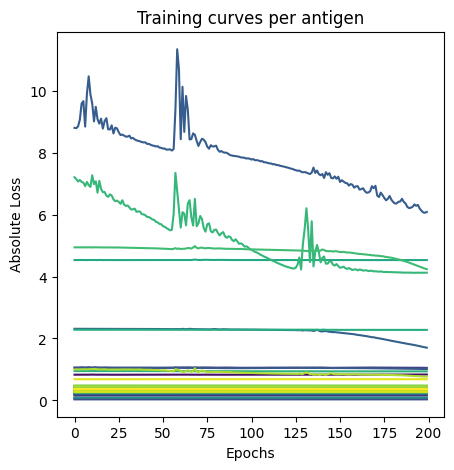

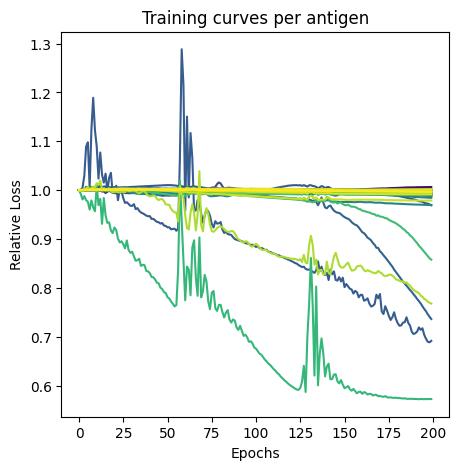

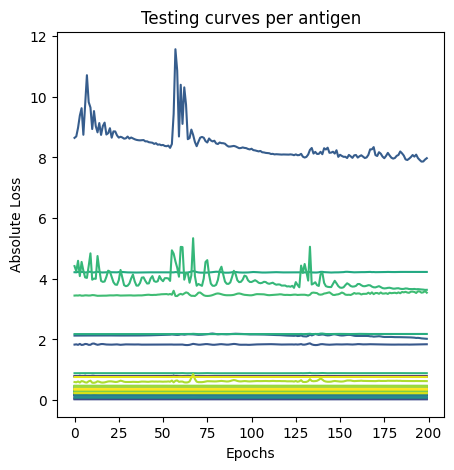

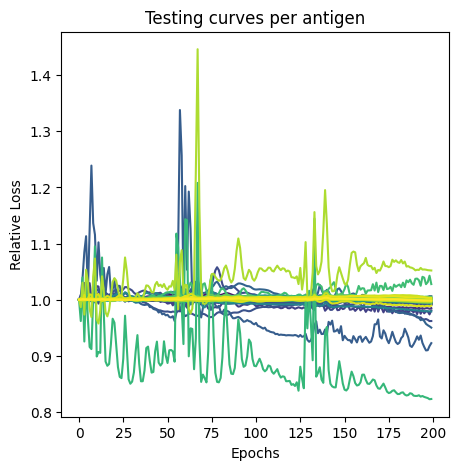

In [37]:
from matplotlib import cm

### plot training losses per antigen
burn_in_epochs = 0
xs = np.arange(burn_in_epochs, EPOCHS)

fig, ax = plt.subplots(figsize=[5, 5])
# Plotting the curves
colors = cm.viridis(np.linspace(0, 1, antigen_loss.shape[1]))
for curve, color in zip(np.array(antigen_loss)[burn_in_epochs:].T, colors):
    plt.plot(xs, curve, color=color)
# plt.plot(np.array(antigen_loss_val)[10:], label='Validation Curves')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Absolute Loss')
plt.title('Training curves per antigen')

# Displaying the plot
plt.show()

wandb.log({"train antigen loss chart": ax})

### plot relative losses
burn_in_epochs = 0
xs = np.arange(burn_in_epochs, EPOCHS)

fig, ax = plt.subplots(figsize=[5, 5])
# Plotting the curves
colors = cm.viridis(np.linspace(0, 1, antigen_loss.shape[1]))
for curve, color in zip(np.array(antigen_loss)[burn_in_epochs:].T, colors):
    plt.plot(xs, curve/curve[0], color=color)
# plt.plot(np.array(antigen_loss_val)[10:], label='Validation Curves')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Relative Loss')
plt.title('Training curves per antigen')

# Displaying the plot
plt.show()

wandb.log({"train antigen rel loss chart": ax})

### plot testing losses per antigen
burn_in_epochs = 0
xs = np.arange(burn_in_epochs, EPOCHS)

fig, ax = plt.subplots(figsize=[5, 5])
# Plotting the curves
colors = cm.viridis(np.linspace(0, 1, antigen_loss.shape[1]))
for curve, color in zip(np.array(antigen_loss_val)[burn_in_epochs:].T, colors):
    plt.plot(xs, curve, color=color)
# plt.plot(np.array(antigen_loss_val)[10:], label='Validation Curves')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Absolute Loss')
plt.title('Testing curves per antigen')

# Displaying the plot
plt.show()

wandb.log({"test antigen loss chart": ax})

### plot relative losses

# plot relative losses
burn_in_epochs = 0
xs = np.arange(burn_in_epochs, EPOCHS)

fig, ax = plt.subplots(figsize=[5, 5])
# Plotting the curves
colors = cm.viridis(np.linspace(0, 1, antigen_loss.shape[1]))
for curve, color in zip(np.array(antigen_loss_val)[burn_in_epochs:].T, colors):
    plt.plot(xs, curve/curve[0], color=color)
# plt.plot(np.array(antigen_loss_val)[10:], label='Validation Curves')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Relative Loss')
plt.title('Testing curves per antigen')

# Displaying the plot
plt.show()

wandb.log({"test antigen rel loss chart": ax})

### Plot average likelihoods under Poisson

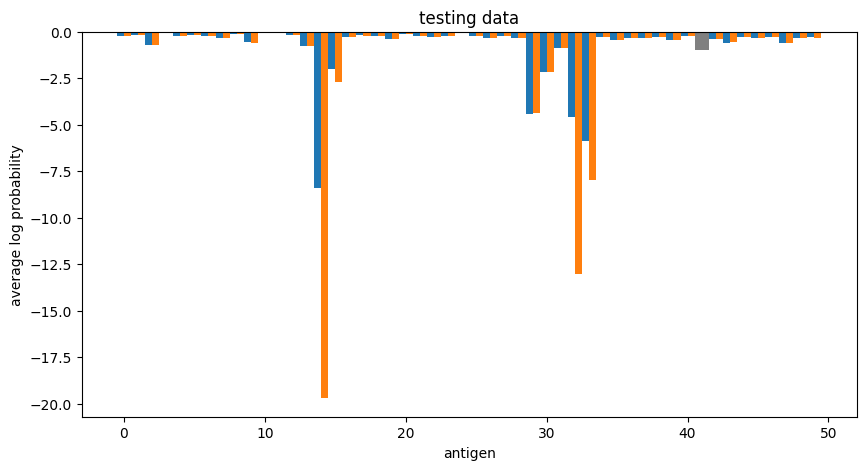

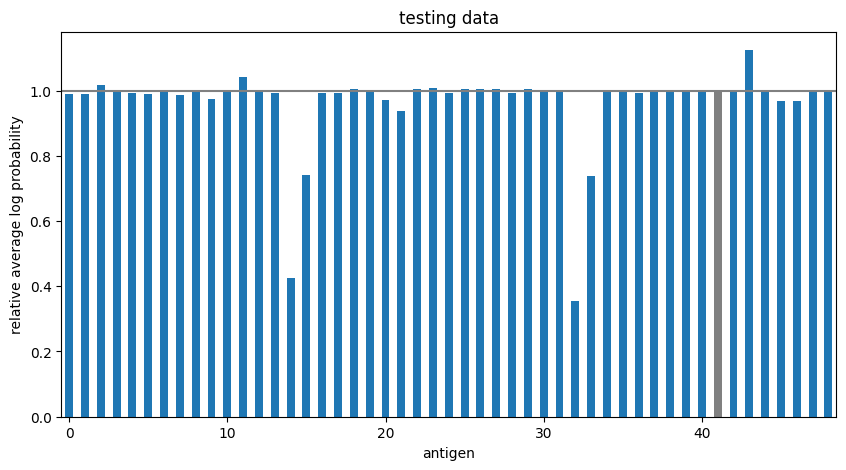

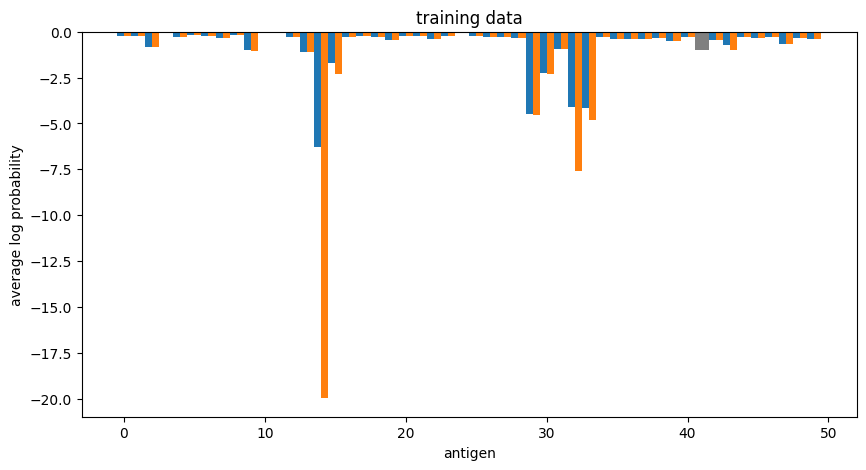

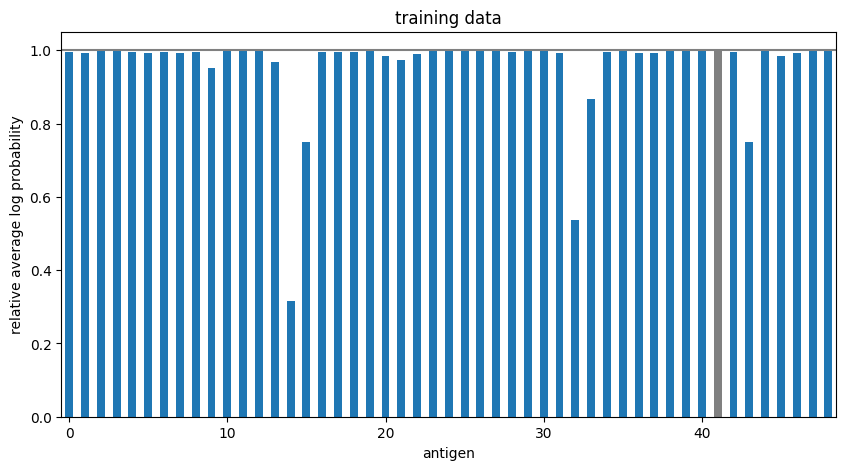

In [38]:
# TODO import interacitve plots into wandb

import torch.nn as nn
from scipy.special import loggamma
loss = nn.PoissonNLLLoss(log_input=True, full=True)

ffn.predict()
ffn.predictions.shape

z = ffn.y_test
log_z_hat = ffn.predictions
z_hat = np.exp(log_z_hat)
log_pois = -z_hat + z * log_z_hat - loggamma(z+1)
av_log_pois = log_pois.mean(axis=0)

trivial_pred = np.average(z, axis=0)
log_pois_trivial = -trivial_pred + z * np.log(trivial_pred) - loggamma(z+1)
av_log_pois_trivial = log_pois_trivial.mean(axis=0)

fig, ax = plt.subplots(figsize=[10, 5])
plt.title("testing data")
ax.bar(hold_in_inds-0.25, av_log_pois, width=0.5)
ax.bar(hold_in_inds+0.25, av_log_pois_trivial, width=0.5)
ax.bar(hold_out_inds, [-1], width=1, color='grey')
plt.ylabel("average log probability")
plt.xlabel("antigen")

wandb.log({"test antigen liks to trivial": wandb.Image(plt)})

fig, ax = plt.subplots(figsize=[10, 5])
plt.title("testing data")
plt.plot([-10, max(hold_in_inds)+10], [1, 1], color='grey')
ax.bar(hold_in_inds, av_log_pois / av_log_pois_trivial, width=0.5)
ax.bar(hold_out_inds, [1], width=0.5, color='grey')
plt.ylabel("relative average log probability")
plt.xlabel("antigen")
# plt.ylim(0, 1)
plt.xlim(-0.5, len(av_log_pois)-0.5)

wandb.log({"test antigen liks ratio to trivial": wandb.Image(plt)})



z_t = ffn.y_train
log_z_hat_t = np.concatenate([get_preds(ffn.x_train[batch_size*i:batch_size*(i+1)])
                               for i in range(n_batches+1)])
z_hat_t = np.exp(log_z_hat_t)
log_pois_t = -z_hat_t + z_t * log_z_hat_t - loggamma(z_t+1)
av_log_pois_t = log_pois_t.mean(axis=0)
# print("average log likelihood:\t\t\t\t", av_log_pois)

trivial_pred_t = np.average(z_t, axis=0)
log_pois_trivial_t = -trivial_pred_t + z_t * np.log(trivial_pred_t) - loggamma(z_t+1)
av_log_pois_trivial_t = log_pois_trivial_t.mean(axis=0)
# print("average log likelihood from trivial pred:\t", av_log_pois_trivial)

fig, ax = plt.subplots(figsize=[10, 5])
plt.title("training data")
plt.bar(hold_in_inds-0.25, av_log_pois_t, width=0.5)
plt.bar(hold_in_inds+0.25, av_log_pois_trivial_t, width=0.5)
ax.bar(hold_out_inds, [-1], width=1, color='grey')
plt.ylabel("average log probability")
plt.xlabel("antigen")

wandb.log({"train antigen liks to trivial": wandb.Image(plt)})


wandb.log({"test antigen liks to trivial": wandb.Image(plt)})

fig, ax = plt.subplots(figsize=[10, 5])
plt.title("training data")
plt.plot([-10, max(hold_in_inds)+10], [1, 1], color='grey')
ax.bar(hold_in_inds, av_log_pois_t / av_log_pois_trivial_t, width=0.5)
ax.bar(hold_out_inds, [1], width=0.5, color='grey')
plt.ylabel("relative average log probability")
plt.xlabel("antigen")
# plt.ylim(0, 1)
plt.xlim(-0.5, len(av_log_pois)-0.5)

wandb.log({"train antigen liks ratio to trivial": wandb.Image(plt)})

### Plot predictions vs real binding

In [39]:
import torch.nn as nn
from scipy.special import loggamma
loss = nn.PoissonNLLLoss(log_input=True, full=True)

for i, ind in enumerate(hold_in_inds):

    print("average log likelihood:\t\t\t\t", av_log_pois[i])
    print("average log likelihood from trivial pred:\t", av_log_pois_trivial[i])

    fig, ax = plt.subplots(2, figsize=[5, 10])
    ax[0].plot(z[:, i], z_hat[:, i], '.')
    max_x = np.max(z[:, i])
    max_y = np.max(z_hat[:, i])
    ax[0].set_xlim(0-0.01-max_x*0.01, max_x*1.01+0.01)
    ax[0].set_ylim(0-0.01-max_y*0.01, max_y*1.01+0.01)
    ax[0].set_ylabel("predicted binding")
    ax[0].set_xlabel("true binding")
    ax[0].set_title(str(ind)+'_'+target_ids[ind])
    ax[0].plot([-max_x, 2*max_x], np.average(z[:, i])*np.ones(2), color='orange')
    ax[0].plot([0, max_x+max_y], [0, max_x+max_y], color='grey')

    ax[1].plot(np.log(1+z[:, i]), np.log(1+z_hat[:, i]), '.')
    max_x = np.max(np.log(1+z[:, i]))
    max_y = np.max(np.log(1+z_hat[:, i]))
    ax[1].set_xlim(0-0.01-max_x*0.01, max_x*1.01+0.01)
    ax[1].set_ylim(0-0.01-max_y*0.01, max_y*1.01+0.01)
    ax[1].set_ylabel("predicted log binding")
    ax[1].set_xlabel("true log binding")
    ax[1].set_title(str(ind)+'_'+target_ids[ind])
    ax[1].plot([-max_x, 2*max_x], np.log(1+np.average(z[:, i]))*np.ones(2), color='orange')
    ax[1].plot([0, max_x+max_y], [0, max_x+max_y], color='grey')
    plt.tight_layout()
    
    wandb.log({"antigen_plots/antigen {}".format(ind): wandb.Image(plt)})
    # plt.show()
    plt.close()
    


average log likelihood:				 -0.23348055681653684
average log likelihood from trivial pred:	 -0.2361641260801994
average log likelihood:				 -0.17664357867980138
average log likelihood from trivial pred:	 -0.1782936882251485
average log likelihood:				 -0.707760976772763
average log likelihood from trivial pred:	 -0.6959017113543454
average log likelihood:				 -0.07128957297440269
average log likelihood from trivial pred:	 -0.07165457550227256
average log likelihood:				 -0.2461399605226387
average log likelihood from trivial pred:	 -0.24767000434808795
average log likelihood:				 -0.15118003681194941
average log likelihood from trivial pred:	 -0.15286862419483943
average log likelihood:				 -0.2057268114480098
average log likelihood from trivial pred:	 -0.20643543276392012
average log likelihood:				 -0.32076768058840155
average log likelihood from trivial pred:	 -0.32527168932593525
average log likelihood:				 -0.14393623225591348
average log likelihood from trivial pred:	 -0.14427593

### Plot representation of counts data

In [40]:
embeddings_t = np.concatenate([get_embeddings(ffn.x_train[batch_size*i:batch_size*(i+1)])
                               for i in range(n_batches+1)])
embeddings = get_embeddings(ffn.x_test)

In [41]:
from sklearn.manifold import TSNE
n_pca_components = 10

scs = np.real(np.linalg.eig(np.dot(embeddings.T, embeddings))[1])
pca = np.dot(embeddings, scs[:, :n_pca_components])
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=20).fit_transform(pca)

In [42]:
from matplotlib import cm

for i, ind in enumerate(hold_in_inds):

    dat = np.log(z[:, i]+1)
    dat = (dat)/(np.max(dat))
    
    dat_hat = np.log(z_hat[:, i]+1)
    dat_hat = (dat_hat)/(np.max(dat_hat))

    fig, ax = plt.subplots(2, figsize=[5, 10])
    ax[0].scatter(X_embedded[:, 0], X_embedded[:, 1], color=cm.viridis(dat), s=6)
    ax[0].set_ylabel("tsne_2", fontsize=20)
    ax[0].set_title(str(ind)+'_'+target_ids[ind] + " real binding")
    
    ax[1].scatter(X_embedded[:, 0], X_embedded[:, 1], color=cm.viridis(dat_hat), s=6)
    ax[1].set_xlabel("tsne_1", fontsize=20)
    ax[1].set_ylabel("tsne_2", fontsize=20)
    ax[1].set_title(str(ind)+'_'+target_ids[ind] + " pred binding")
    plt.tight_layout()
    wandb.log({"antigen_rep_plots/antigen rep {}".format(ind): wandb.Image(plt)})
    # plt.show()
    plt.close()
    
for i, ind in enumerate(hold_out_inds):
    dat = np.log(y_test[:, ind]+1)
    dat = (dat)/(np.max(dat))

    fig, ax = plt.subplots(1, figsize=[5, 5])
    ax.scatter(X_embedded[:, 0], X_embedded[:, 1], color=cm.viridis(dat), s=6)
    ax.set_ylabel("tsne_2", fontsize=20)
    ax.set_title(str(ind)+'_'+target_ids[ind] + " real binding")
    plt.tight_layout()
    wandb.log({"antigen_rep_plots/held out antigen rep {}".format(ind): wandb.Image(plt)})
    # plt.show()
    plt.close()

## Save the model

In [ ]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(f'{indir}{timestamp}.saved_model', exist_ok=True)
# save_yhat means save predictions
ffn.save_model_full(f'{indir}{timestamp}.saved_model', save_yhat=False, save_train_data=True)

np.save(f'{indir}{timestamp}.saved_model/hold_in_inds.npy', hold_in_inds)
np.save(f'{indir}{timestamp}.saved_model/preds.npy', np.r_[z_hat_t, z_hat])
np.save(f'{indir}{timestamp}.saved_model/embeddings.npy', np.r_[embeddings_t, embeddings])

In [ ]:
# reinit instead
wandb.finish()

## Reproduce evaluation in a new instance of model w/ same weights

We load the model, with weights and data included, and evaluate and predict on the test data

In [76]:
all_seqs_ohe = np.concatenate([ffn.x_train, ffn.x_test], axis=0)[:, 0, :, :-1].astype(bool)
all_ys = np.log(1 + np.concatenate([ffn.y_train, ffn.y_test], axis=0))

seqs = all_seqs_ohe
ys = all_ys
n_cov = ys.shape[1]

In [69]:
np.r_[embeddings_t, embeddings].shape

(56887, 64)

In [70]:
np.r_[z_hat_t, z_hat].shape

(56887, 50)

In [75]:
ffn2.x_train.shape

(51318, 1, 40, 26)

In [67]:
ffn2 = tm.models.EstimatorFfn()
ffn2.load_model_full(fn=f'{indir}{timestamp}.saved_model')
# print(ffn2.evaluate(test_only=True))
# # saves to ffn2.predictions
# ffn2.predict()

0 2
1 2


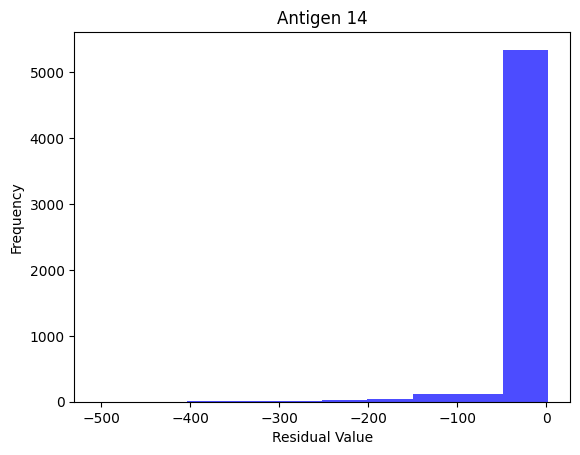

In [ ]:
ffn.get_residuals(14)